Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

Dado:

Habitación de MxN espacios.
Número de agentes.
Porcentaje de celdas inicialmente sucias.
Tiempo máximo de ejecución.
Realiza la siguiente simulación:

Inicializa las celdas sucias (ubicaciones aleatorias).
Todos los agentes empiezan en la celda [1,1].
En cada paso de tiempo:
Si la celda está sucia, entonces aspira.
Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).

In [13]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid


from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time as tm
import datetime

In [14]:
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
      

    def step(self):
        if (self.model.floor[self.pos[0]][self.pos[1]] == 1):
            self.clean()
        self.move()

    def clean(self):
        x, y = self.pos
        self.model.floor[x][y] = 0


    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        empty_steps = [
            step for step in possible_steps if self.model.grid.is_cell_empty(step)]

        if empty_steps:
            new_position = self.random.choice(empty_steps)
            self.model.grid.move_agent(self, new_position)


class CleaningModel(Model):
    def __init__(self, N, width, height, percentDirtyCells):
        self.num_agents = N
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.width = width
        self.height = height
        
        self.floor = np.zeros((width, height))

        # set the floor with dirty cells
        for i in range(width):
            for j in range(height):
                if np.random.random() < percentDirtyCells:
                    self.floor[i][j] = 1
        
    

        for i in range(self.num_agents):
            a = CleaningAgent(i, self)
            self.grid.place_agent(a, (1,1))
            self.schedule.add(a)

        self.datacollector = DataCollector(
            model_reporters={"Dirt": lambda m: self.countDirtyCells(), "Position": lambda m: self.countAgentsPosition()})

    def countDirtyCells(self):
        return self.floor.copy()
    
    def getPercentageClean(self,percentDirtyCells):
        percent = (self.width * self.height * percentDirtyCells - sum(sum(self.floor))
                   ) / (self.width * self.height * percentDirtyCells) * 100
        percent = int(percent * 100) / 100
        return percent 
    
    def countAgentsPosition(self):
        agentsPosition = np.zeros((self.width, self.height))
        for agent in self.schedule.agents:
            x, y = agent.pos
            agentsPosition[x][y] = 1
        return agentsPosition


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()



WIDTH = 10
HEIGHT = 10
NUM_AGENTS = 2
MAX_ITER = 1000

model = CleaningModel(NUM_AGENTS, WIDTH, HEIGHT, 0.5)

for i in range(MAX_ITER):
    model.step()
    if(model.floor.sum() == 0):
        break

# Simulation

In [15]:
all_positions = model.datacollector.get_model_vars_dataframe()

# animate the agent 

fig, axis = plt.subplots(figsize=(6, 6))
axis.set_xticks([])
axis.set_yticks([])
data = all_positions.get("Dirt") + 3 * all_positions.get("Position")
agent_data = all_positions.get("Position")





total_steps = len(all_positions)
step = max(1,total_steps//500)
data = data.iloc[::step].reset_index(drop=True)
agent_data = agent_data.iloc[::step].reset_index(drop=True)



patch = plt.imshow(data[0], cmap=plt.cm.binary)
plt.close()


def animateDirty(frame):
    patch.set_data(data[frame])




anim = animation.FuncAnimation(fig, animateDirty, frames=len(data))

anim



## Obtain Stats

In [16]:
def cleanCollect(N, width, height, percentDirtyCells, MAX_ITER):
    model = CleaningModel(N, width, height, percentDirtyCells)
    start_time = tm.time()
    steps_to_clean = 0
    for i in range(MAX_ITER):
        model.step()
        steps_to_clean += 1
        if(model.floor.sum() == 0):
            break
    end_time = tm.time()

    time = end_time - start_time
    time = int(time * 100) / 100

    percentClean = model.getPercentageClean(percentDirtyCells)
    return [time, percentClean]


In [17]:
def cleanAllCollect(N, width, height, percentDirtyCells):
    model = CleaningModel(N, width, height, percentDirtyCells)
    start_time = tm.time()
    steps_to_clean = 0
    while(model.floor.sum() != 0):
        model.step()
        steps_to_clean += 1
    end_time = tm.time()

    time = end_time - start_time
    time = int(time * 100) / 100

    percentClean = model.getPercentageClean(percentDirtyCells)
    return [time, percentClean, steps_to_clean]

# Scenario 1

Agents: 1
Dirty cells: 90%

In [18]:
NUM_AGENTS = 1
MAX_ITER = 100
WIDTH = 100
HEIGHT = 100
DIRTY_CELLS = 0.9

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("Stadistics with 100 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])

MAX_ITER = 1000

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("\nStadistics with 1000 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])

MAX_ITER = 10000

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("\nStadistics with 10000 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])

Stadistics with 100 iterations: 

Time:  0.01 seconds
Percent Clean:  -0.23

Stadistics with 1000 iterations: 

Time:  0.1 seconds
Percent Clean:  4.82

Stadistics with 10000 iterations: 

Time:  1.11 seconds
Percent Clean:  31.24


# Scenario 2

Agents: 2
Dirty cells: 90%

In [19]:
NUM_AGENTS = 2
MAX_ITER = 100
WIDTH = 100
HEIGHT = 100
DIRTY_CELLS = 0.9

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("Stadistics with 100 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])


MAX_ITER = 1000

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("\nStadistics with 1000 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])


MAX_ITER = 10000

stats = cleanCollect(NUM_AGENTS, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)

print("\nStadistics with 10000 iterations: \n")
print("Time: ", stats[0], "seconds")
print("Percent Clean: ", stats[1])


Stadistics with 100 iterations: 

Time:  0.01 seconds
Percent Clean:  1.34

Stadistics with 1000 iterations: 

Time:  0.11 seconds
Percent Clean:  5.97

Stadistics with 10000 iterations: 

Time:  1.29 seconds
Percent Clean:  51.71


# General statistics

In [20]:
NUM_AGENTS = [1,2,3,4,5,6,7,8,9,10]
MAX_ITER = 10000
WIDTH = 100
HEIGHT = 100
DIRTY_CELLS = 0.9

statsCollect = []

for num in NUM_AGENTS:
    stats = cleanCollect(num, WIDTH, HEIGHT, DIRTY_CELLS, MAX_ITER)
    statsCollect.append(stats)
    print("\n Stadistics with ", num, " agents and 10000 iterations: \n")
    print("Time: ", stats[0], "seconds")
    print("Percent Clean: ", stats[1])


 Stadistics with  1  agents and 10000 iterations: 

Time:  1.07 seconds
Percent Clean:  30.73

 Stadistics with  2  agents and 10000 iterations: 

Time:  1.18 seconds
Percent Clean:  52.94

 Stadistics with  3  agents and 10000 iterations: 

Time:  1.17 seconds
Percent Clean:  63.73

 Stadistics with  4  agents and 10000 iterations: 

Time:  1.24 seconds
Percent Clean:  70.58

 Stadistics with  5  agents and 10000 iterations: 

Time:  1.26 seconds
Percent Clean:  72.16

 Stadistics with  6  agents and 10000 iterations: 

Time:  1.35 seconds
Percent Clean:  86.88

 Stadistics with  7  agents and 10000 iterations: 

Time:  1.43 seconds
Percent Clean:  79.12

 Stadistics with  8  agents and 10000 iterations: 

Time:  1.45 seconds
Percent Clean:  95.44

 Stadistics with  9  agents and 10000 iterations: 

Time:  1.92 seconds
Percent Clean:  82.6

 Stadistics with  10  agents and 10000 iterations: 

Time:  0.81 seconds
Percent Clean:  88.64


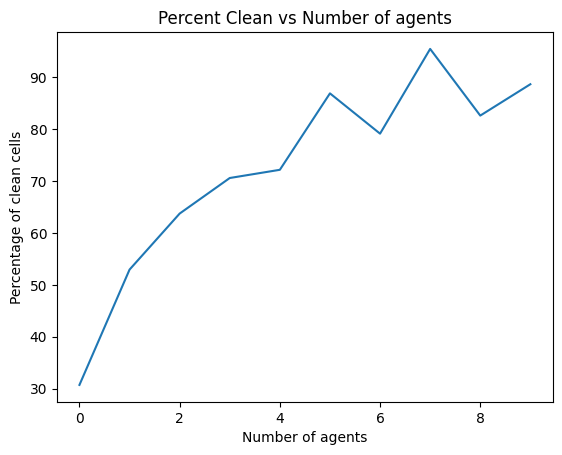

In [21]:

percentClean = []
times = []
steps = []

NUM = len(statsCollect)


for i in range(NUM):
    stats = statsCollect[i]
    percentClean.append(stats[1])

plt.plot(range(0, NUM), percentClean)
plt.xlabel("Number of agents")
plt.ylabel("Percentage of clean cells")
plt.title("Percent Clean vs Number of agents")
plt.show()

# Stadistics to clean all the space

In [22]:
statsCollect = []
times = []
steps = []

for num in NUM_AGENTS:
    stats = cleanAllCollect(num, WIDTH, HEIGHT, DIRTY_CELLS)
    statsCollect.append(stats)
    times.append(stats[0])
    steps.append(stats[2])

[266971, 193448, 106466, 83202, 51537, 45968, 55660, 54960, 33228, 31382]


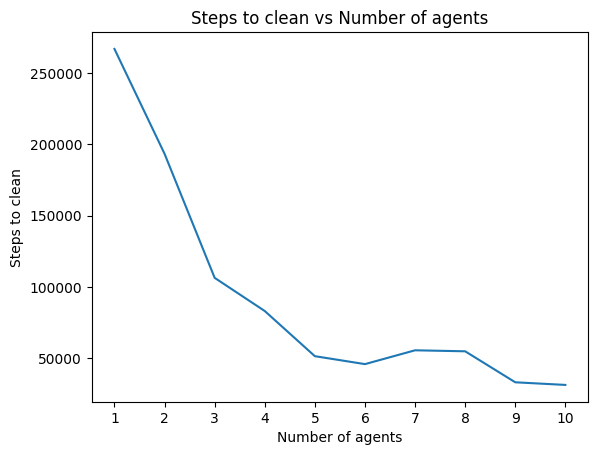

In [26]:
NUM = len(statsCollect)

fig, ax = plt.subplots()
ax.set(xticks=range(0, NUM), xticklabels=NUM_AGENTS)
ax.plot(range(0, NUM), steps)
print(steps)
plt.xlabel("Number of agents")
plt.ylabel("Steps to clean")
plt.title("Steps to clean vs Number of agents")

plt.show()

[23.67, 21.9, 25.14, 10.91, 6.19, 4.75, 12.11, 4.21, 2.56, 3.78]


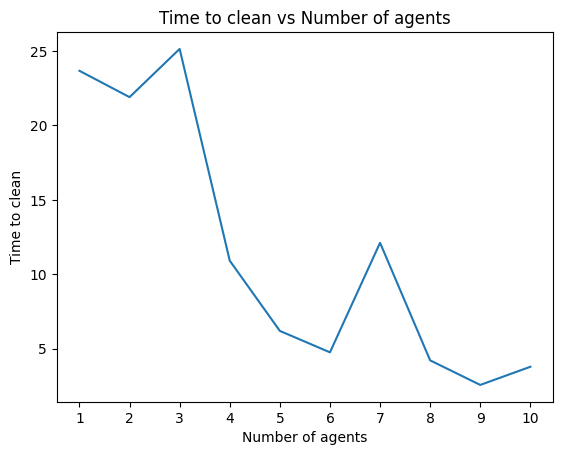

In [25]:
fig,ax = plt.subplots()
ax.set(xticks=range(0, NUM), xticklabels=NUM_AGENTS)
ax.plot(range(0, NUM), times)
plt.xlabel("Number of agents")
plt.ylabel("Time to clean")
plt.title("Time to clean vs Number of agents")



plt.show()